#INST414 Final Project

- Name: Ruthwik Kuppachi
- Date: 05/10/2021


##Introduction

In this project, I have applied five different alogrithms to solve a binary classification problem: buidling a model and predicting whether an asteroid is a "Potentially Hazardous Asteroid" (PHA) or not. The five algorithms are:
- Logistic Regression
- Decision Trees
- XGBoost
- Keras Neural Networks
- PyTorch Neural Networks

The dataset used for this project is titled "Asteroid Features For Hazardous Prediction / NASA" and is obtained from Kaggle (https://www.kaggle.com/brsdincer/asteroid-classification-for-hazardous-prediction). This dataset contains 31 columns, that describe various aspects about asteroids, and 839,714 rows where each row is an asteroid in our solar system. Some of the columns are semi-major axis (in astronomical units, AU), eccentricity of the asteroid's orbit, perihelion distance (in AU), aphelion distance (in AU), neo or Near-Earth Object, pha or Potentially Hazardous Asteroid, etc. 

The target variable is the neo which only takes on two values - 'Y' or 'N'. Hence, this is a binary classification problem.

Upon some research and with some help from the Kaggle website, it was determined that only certain variables, that are mentioned below, are suitable to be used in these models. Therefore, before building these models, it is necessary to perform some data wrangling.

Columns that will be used to fit the models: 
- a - semi-major axis(au)
- e - eccentricity
- i - Inclination with respect to x-y ecliptic plane(deg)
- om - Longitude of the ascending node
- w - argument of perihelion
- q - perihelion distance(au)
- ad - aphelion distance(au)
- per_y - Orbital period(YEARS)
- H - Absolute Magnitude parameter
- neo - Near Earth Object / N or Y
- pha - Physically Hazardous Asteroid - N or Y
- moid - Earth Minimum orbit Intersection Distance(au)
- n - Mean motion(deg/d)
- per - orbital Period(d)
- ma - Mean anomaly(deg)

In [1]:
#Imports
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import xgboost as xgb
from xgboost import plot_importance
from keras.models import Sequential
from keras.layers import Dense
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Load the dataset
asteroid_data = pd.read_csv('./drive/MyDrive/Asteroid_Updated.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,10,15,16,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Dropping columns that won't be used for fitting the model
asteroid_data.drop(['diameter', 'extent', 'albedo', 'rot_per', 'GM', 'BV', 'UB', 'IR', 'spec_B', 'spec_T', 'G',
                    'data_arc', 'condition_code', 'n_obs_used', 'class', 'name'], axis = 1, inplace= True)

##Overview of Data

In [4]:
print(asteroid_data.shape)
asteroid_data.head()

(839714, 15)


,a,e,i,om,w,q,ad,per_y,H,neo,pha,moid,n,per,ma
0,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,3.34,N,N,1.59478,0.213885,1683.145708,77.372096
1,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,4.13,N,N,1.23324,0.213503,1686.155999,59.699133
2,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,5.33,N,N,1.03454,0.226019,1592.787285,34.925016
3,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,3.20,N,N,1.13948,0.271609,1325.432765,95.861936
4,2.574249,0.191095,5.366988,141.576605,358.687607,2.082324,3.066174,4.130323,6.85,N,N,1.09589,0.238632,1508.600458,282.366289


In [5]:
asteroid_data.describe()

,a,e,i,om,w,q,ad,per_y,H,moid,n,per,ma
count,839712.000000,839714.000000,839714.000000,839714.000000,839714.000000,839714.000000,839708.000000,839713.000000,837025.000000,8.232720e+05,8.397120e+05,8.397080e+05,839706.000000
mean,2.757514,0.155636,8.949826,168.499466,181.075796,2.404728,3.385710,6.859734,16.786249,1.423371e+00,2.374145e-01,2.505533e+03,180.659892
std,114.384959,0.093897,6.666087,103.096307,104.023854,2.233172,12.748733,252.264249,1.821574,2.250450e+00,8.095014e-02,9.213979e+04,106.562235
min,-104279.220927,0.000000,0.007546,0.000388,0.001666,0.070511,0.773684,0.000000,-1.100000,3.437640e-07,2.926897e-08,1.511339e+02,-67.136826
25%,2.385258,0.091454,4.069077,80.211400,91.041603,1.971941,2.775350,3.683928,15.900000,9.784998e-01,1.900553e-01,1.345555e+03,86.642618
50%,2.644219,0.143655,7.257101,160.294860,181.669478,2.225510,3.037761,4.299859,16.800000,1.237810e+00,2.292228e-01,1.570524e+03,181.517775
75%,2.996048,0.199400,12.255653,252.201519,271.521717,2.578162,3.357967,5.185985,17.600000,1.590560e+00,2.675475e-01,1.894184e+03,274.301731
max,3043.149073,1.201134,175.188725,359.999800,359.999833,80.424175,6081.841956,167877.712688,33.200000,7.950130e+01,2.381994e+00,6.131733e+07,491.618014


In [6]:
# Data types
asteroid_data.dtypes

a        float64
e        float64
i        float64
om       float64
w        float64
q        float64
ad       float64
per_y    float64
H        float64
neo       object
pha       object
moid     float64
n        float64
per      float64
ma       float64
dtype: object

In [7]:
# Number of NAs
asteroid_data.isna().sum()

a            2
e            0
i            0
om           0
w            0
q            0
ad           6
per_y        1
H         2689
neo          6
pha      16442
moid     16442
n            2
per          6
ma           8
dtype: int64

## Data Wrangling and EDA

In [8]:
# Drop nas from all columns
asteroid_data.dropna(inplace=True)

In [9]:
#Verify that nas are dropped
asteroid_data.isna().sum()

a        0
e        0
i        0
om       0
w        0
q        0
ad       0
per_y    0
H        0
neo      0
pha      0
moid     0
n        0
per      0
ma       0
dtype: int64

In [10]:
# Encode pha, a categorical variable, as int: 0 - not pha, 1 - pha
encode = LabelEncoder()

asteroid_data["pha"] = encode.fit_transform(asteroid_data["pha"])
dfCorr = asteroid_data.select_dtypes(include=["float64", "int64", "int32"])

In [11]:
# Verify that encoding took place
asteroid_data.head()

,a,e,i,om,w,q,ad,per_y,H,neo,pha,moid,n,per,ma
0,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,3.34,N,0,1.59478,0.213885,1683.145708,77.372096
1,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,4.13,N,0,1.23324,0.213503,1686.155999,59.699133
2,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,5.33,N,0,1.03454,0.226019,1592.787285,34.925016
3,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,3.20,N,0,1.13948,0.271609,1325.432765,95.861936
4,2.574249,0.191095,5.366988,141.576605,358.687607,2.082324,3.066174,4.130323,6.85,N,0,1.09589,0.238632,1508.600458,282.366289


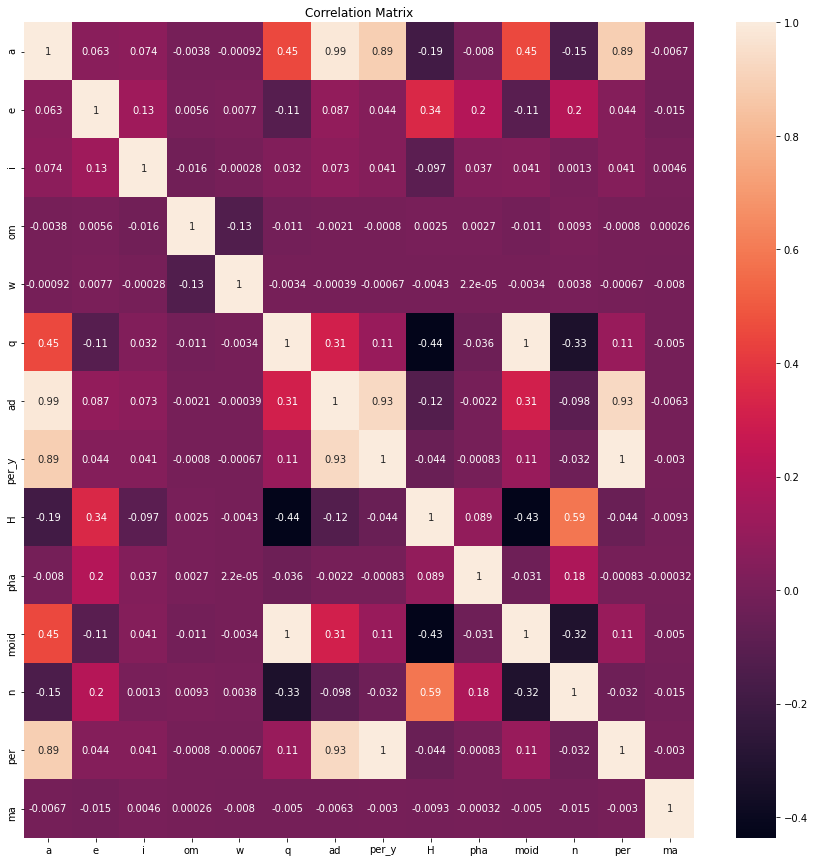

In [35]:
# Correlation matrix
plt.figure(figsize=(15,15))
corrMatrix = asteroid_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

In [13]:
#Dropping the neo column since it is perfectly correlated with our target variable pha
asteroid_data.drop(['neo'], axis = 1, inplace = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5310af190>,
      dtype=object)

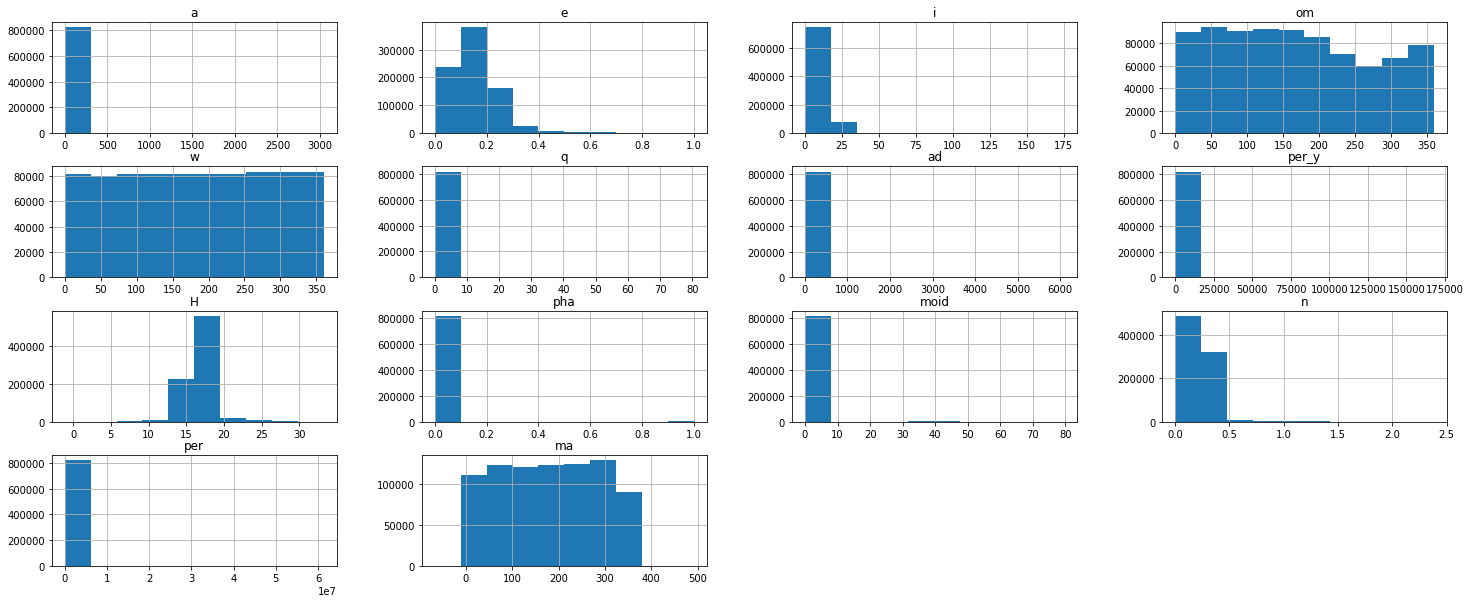

In [42]:
#Histograms for all numeric columns to understand the distribution of variables
asteroid_data.hist(bins=10, figsize=(25, 10))

Counter({0: 818557, 1: 2015})


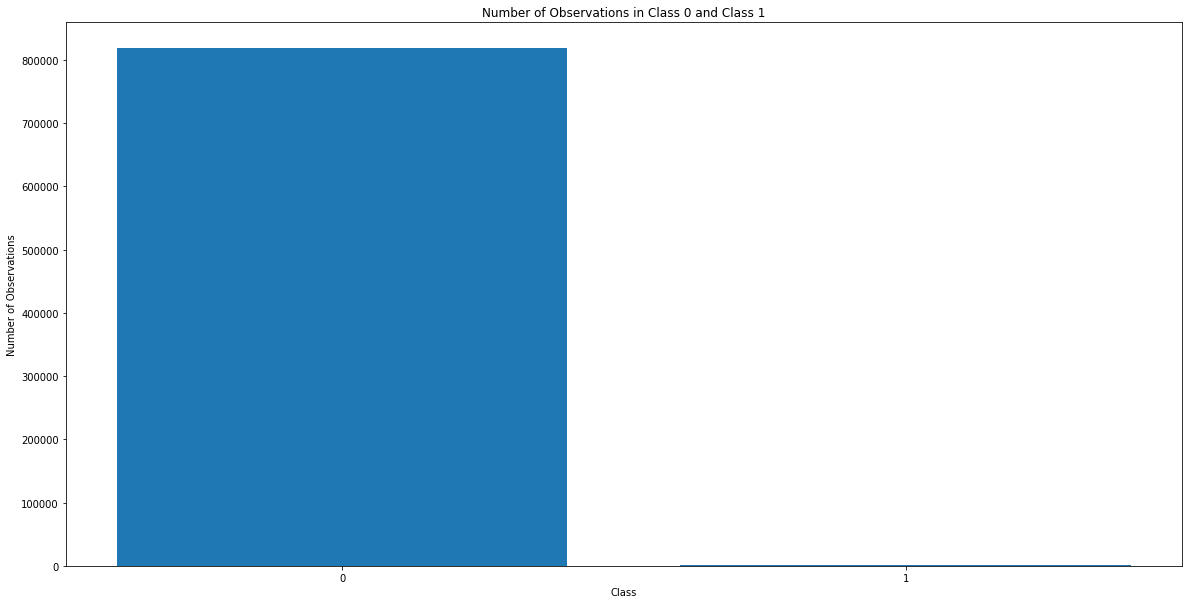

In [34]:
# Checking for data imbalance: plotting positive and negative classes of pha
lab = list(Counter(asteroid_data['pha']).keys())
values = list(Counter(asteroid_data['pha']).values())
plt.figure(figsize=(20,10))
plt.bar(range(len(lab)), values, tick_label = lab)
plt.title('Number of Observations in Class 0 and Class 1')
plt.xlabel('Class')
plt.ylabel('Number of Observations')
print(Counter(asteroid_data['pha']))

In [15]:
# Defininig feature and target variables
X = asteroid_data.loc[:, asteroid_data.columns != 'pha']
y= asteroid_data.pha

In [16]:
# Initializing SMOTE that oversamples the minority class for better model performance
oversample = SMOTE()

## Data Wrangling and EDA Explanation

First of all, all columns that will not be included in the models like name of asteroid, diameter of asteroid, etc. have been dropped from the original dataframe so that analysis and model building can be simplified. After this was accomplished, I decided to drop all NAs from this dataset because there weren't a lot of them compared to the total size of the dataset and most of the NAs were in the target variable's column. Then, I encoded the target, which was originally categorical (Y or N) as an integer where 1 indicates that a given asteroid is PHA and 0 indicates that it is not.

Afterwards, a correlation matrix was created to visualize how the target variable was related to other variables in the dataset. During this process, it was discovered that 'neo' is perfectly correlated with the target variable. Therefore, I removed this column from the dataset so that the model can deliver accurate results. 

Another issue that was found in the data visualizations was that the negative class (class 0) has around 818,557 values, and is over-represented whereas the positive class only has 2015 values. This imbalance will cause issues with model performance as the positive class will be more sensitive to classification errors and therefore prediction will be poorer for the positive class. Therefore, I have made use of the SMOTE package to resample the data and to obtain an equal amount of positive and negative classes. 

## Logistic Regression

In [84]:
# Create the training and test sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=99)

In [85]:
# Oversampling only the training set to counter the imbalance
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train)
X_train_oversampled = pd.DataFrame(X_train_oversampled, columns=X_train.columns)
y_train_oversampled = pd.Series(y_train_oversampled)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [86]:
# Setting up the Logistic Regression Model
LogReg = LogisticRegression(max_iter=2000)

# Scaling the data
scaler = preprocessing.StandardScaler()
X_train_oversampled = scaler.fit_transform(X_train_oversampled)
X_test = scaler.transform(X_test)

LogReg.fit(X_train_oversampled,y_train_oversampled)

y_pred=LogReg.predict(X_test)

In [87]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    163720
           1       0.29      1.00      0.45       395

    accuracy                           0.99    164115
   macro avg       0.65      1.00      0.72    164115
weighted avg       1.00      0.99      1.00    164115



In [88]:
# Scores
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score( y_test, y_pred))

Accuracy: 0.9941199768455047
Precision: 0.29044117647058826
Recall: 1.0
F1: 0.45014245014245013


In [89]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[162755,    965],
       [     0,    395]])

Text(0.5, 257.44, 'Predicted label')

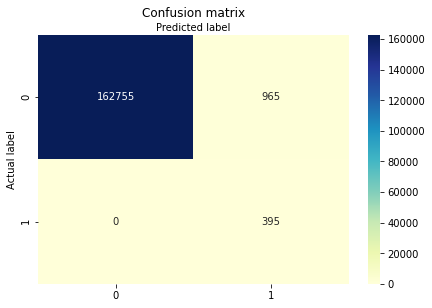

In [90]:
categories = [0,1] 
fig, ax = plt.subplots()
plt.xticks([0,1], categories)
plt.yticks([0,1], categories)
# create heatmap
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Decision Trees

In [91]:
# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.20,random_state=99)

# Oversampling only the training set to counter the imbalance
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train)
X_train_oversampled = pd.DataFrame(X_train_oversampled, columns=X_train.columns)
y_train_oversampled = pd.Series(y_train_oversampled)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [92]:
# No scaling required for Decision/XGBoost
clf = DecisionTreeClassifier(criterion='entropy', random_state=99)
clf.fit(X_train_oversampled,y_train_oversampled)
y_pred= clf.predict(X_test)

In [93]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    163720
           1       0.97      0.98      0.97       395

    accuracy                           1.00    164115
   macro avg       0.98      0.99      0.99    164115
weighted avg       1.00      1.00      1.00    164115



In [94]:
# Scores
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score( y_test, y_pred))

Accuracy: 0.99987813423514
Precision: 0.9699248120300752
Recall: 0.979746835443038
F1: 0.9748110831234257


In [95]:
#Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[163708,     12],
       [     8,    387]])

Text(0.5, 257.44, 'Predicted label')

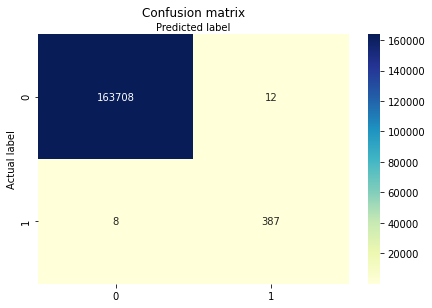

In [96]:
categories = [0,1] 
fig, ax = plt.subplots()
plt.xticks([0,1], categories)
plt.yticks([0,1], categories)
# create heatmap
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

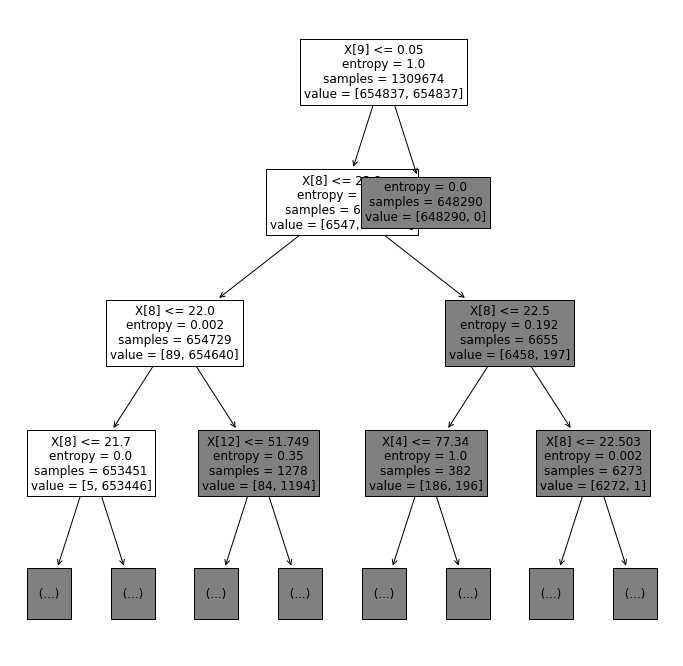

In [97]:
# Tree Diagram
fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(decision_tree=clf, max_depth= 3,fontsize=12);

## XGBoost

In [77]:
# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.20,random_state=99)

# Oversampling only the training set to counter the imbalance
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train)
X_train_oversampled = pd.DataFrame(X_train_oversampled, columns=X_train.columns)
y_train_oversampled = pd.Series(y_train_oversampled)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [78]:
# Instantiate the XGBClassifier
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=99)

xg_cl.fit(X_train_oversampled, y_train_oversampled)

y_pred = xg_cl.predict(X_test)

In [79]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    163720
           1       0.93      1.00      0.96       395

    accuracy                           1.00    164115
   macro avg       0.97      1.00      0.98    164115
weighted avg       1.00      1.00      1.00    164115



In [81]:
#Scores
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score( y_test, y_pred))

Accuracy: 0.99981720135271
Precision: 0.9314420803782506
Recall: 0.9974683544303797
F1: 0.9633251833740831


In [82]:
#Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[163691,     29],
       [     1,    394]])

Text(0.5, 257.44, 'Predicted label')

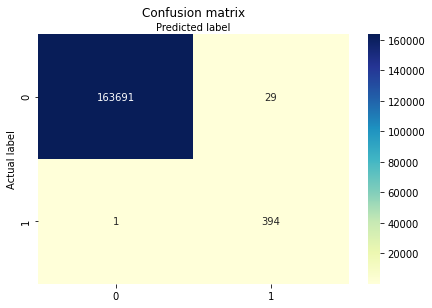

In [83]:
categories = [0,1] 
fig, ax = plt.subplots()
plt.xticks([0,1], categories)
plt.yticks([0,1], categories)
# create heatmap
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

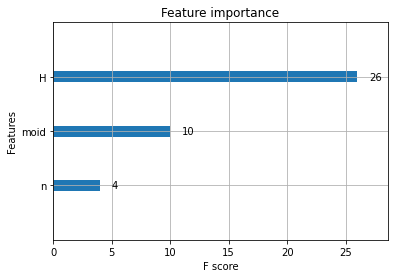

In [120]:
plot_importance(xg_cl)
plt.show()

## Neural Network - Keras

In [98]:
#Building the model
model = Sequential()

#Input shape is 13 because there are 13 features
model.add(Dense(1, input_shape=(13,), activation='sigmoid'))

# Compile your model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [99]:
# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.20,random_state=99)

# Oversampling only the training set to counter the imbalance
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train)
X_train_oversampled = pd.DataFrame(X_train_oversampled, columns=X_train.columns)
y_train_oversampled = pd.Series(y_train_oversampled)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [100]:
# Fitting the model
model.fit(X_train_oversampled, y_train_oversampled, epochs = 20)

Epoch 1/20
40928/40928 [==============================] - 44s 1ms/step - loss: 1819.4180 - accuracy: 0.6983
Epoch 2/20
40928/40928 [==============================] - 44s 1ms/step - loss: 1023.6309 - accuracy: 0.7774
Epoch 3/20
40928/40928 [==============================] - 43s 1ms/step - loss: 962.6073 - accuracy: 0.7977
Epoch 4/20
40928/40928 [==============================] - 43s 1ms/step - loss: 2812.2487 - accuracy: 0.8073
Epoch 5/20
40928/40928 [==============================] - 44s 1ms/step - loss: 17375.8170 - accuracy: 0.8129
Epoch 6/20
40928/40928 [==============================] - 43s 1ms/step - loss: 1827.7571 - accuracy: 0.8382
Epoch 7/20
40928/40928 [==============================] - 43s 1ms/step - loss: 1047.4280 - accuracy: 0.8421
Epoch 8/20
40928/40928 [==============================] - 43s 1ms/step - loss: 777.2847 - accuracy: 0.8481
Epoch 9/20
40928/40928 [==============================] - 43s 1ms/step - loss: 14699.9121 - accuracy: 0.8328
Epoch 10/20
40928/40928 [===

In [101]:
#Predictions
y_preds = model.predict(X_test)

In [102]:
#Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    163720
           1       0.97      0.98      0.97       395

    accuracy                           1.00    164115
   macro avg       0.98      0.99      0.99    164115
weighted avg       1.00      1.00      1.00    164115



In [108]:
#Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[163708,     12],
       [     8,    387]])

Text(0.5, 257.44, 'Predicted label')

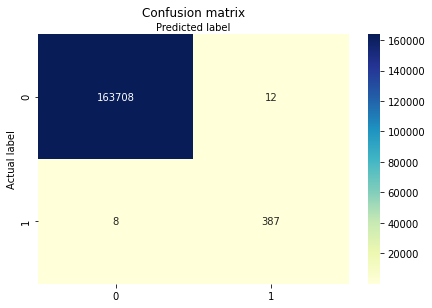

In [109]:
categories = [0,1] 
fig, ax = plt.subplots()
plt.xticks([0,1], categories)
plt.yticks([0,1], categories)
# create heatmap
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [116]:
accuracy = model.evaluate(X_test, y_test)[1]
# Print accuracy
print('Accuracy:', accuracy)
precision = conf_mat[1,1]/(conf_mat[1,1] + conf_mat[0,1])
print('Precision:', precision)
recall = conf_mat[1,1]/(conf_mat[1,1] + conf_mat[1,0])
print('Recall:', recall)
print('F1 Score:', (2*precision*recall)/(precision + recall))

5129/5129 [==============================] - 5s 968us/step - loss: 83.6766 - accuracy: 0.9204
Accuracy: 0.9204460382461548
Precision: 0.9699248120300752
Recall: 0.979746835443038
F1 Score: 0.9748110831234257


## Neural Networks - PyTorch

In [25]:
# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.20,random_state=99)

# Oversampling only the training set to counter the imbalance
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train)
X_train_oversampled = pd.DataFrame(X_train_oversampled, columns=X_train.columns)
y_train_oversampled = pd.Series(y_train_oversampled)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [26]:
# Scale the data for the model
scaler = preprocessing.StandardScaler()
X_train_oversampled = scaler.fit_transform(X_train_oversampled)
X_test = scaler.transform(X_test)

In [27]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train_oversampled), 
                       torch.FloatTensor(y_train_oversampled))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [28]:
# Preparing the test and train data
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [30]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 13.
        self.layer_1 = nn.Linear(13, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [31]:
device = torch.device("cpu")
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
#Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

binaryClassification(
  (layer_1): Linear(in_features=13, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
def binary_acc(y_pred, y_test):
    
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
# 20 epoch
for e in range(1, 21):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.01178 | Acc: 99.675
Epoch 002: | Loss: 0.00635 | Acc: 99.817
Epoch 003: | Loss: 0.00517 | Acc: 99.854
Epoch 004: | Loss: 0.00458 | Acc: 99.864
Epoch 005: | Loss: 0.00429 | Acc: 99.875
Epoch 006: | Loss: 0.00414 | Acc: 99.879
Epoch 007: | Loss: 0.00381 | Acc: 99.888
Epoch 008: | Loss: 0.00368 | Acc: 99.892
Epoch 009: | Loss: 0.00352 | Acc: 99.897
Epoch 010: | Loss: 0.00325 | Acc: 99.906
Epoch 011: | Loss: 0.00327 | Acc: 99.906
Epoch 012: | Loss: 0.00320 | Acc: 99.908
Epoch 013: | Loss: 0.00296 | Acc: 99.915
Epoch 014: | Loss: 0.00300 | Acc: 99.911
Epoch 015: | Loss: 0.00301 | Acc: 99.917
Epoch 016: | Loss: 0.00283 | Acc: 99.918
Epoch 017: | Loss: 0.00281 | Acc: 99.917
Epoch 018: | Loss: 0.00272 | Acc: 99.921
Epoch 019: | Loss: 0.00273 | Acc: 99.922
Epoch 020: | Loss: 0.00264 | Acc: 99.921


In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
# Classification Report
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    163720
           1       0.61      1.00      0.75       395

    accuracy                           1.00    164115
   macro avg       0.80      1.00      0.88    164115
weighted avg       1.00      1.00      1.00    164115



In [ ]:
# Scores
print("Accuracy:", accuracy_score(y_test, y_pred_list))
print("Precision:", precision_score(y_test, y_pred_list))
print("Recall:", recall_score(y_test, y_pred_list))
print("F1:", f1_score( y_test, y_pred_list))

Accuracy: 0.998440118209792
Precision: 0.6070878274268104
Recall: 0.9974683544303797
F1: 0.7547892720306513


In [ ]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_list)

Text(0.5, 257.44, 'Predicted label')

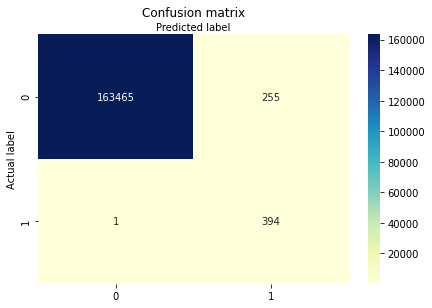

In [ ]:
categories = [0,1] 
fig, ax = plt.subplots()
plt.xticks([0,1], categories)
plt.yticks([0,1], categories)
# create heatmap
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Analysis and Conclusion

All of the algorithms have now been built and appropriate metrics have been calculated. Since we are dealing with a higly imbalanced dataset, accuracy is not the best evaluation metric. Therefore, to compare the performance of these models, it is better to take a look at the precision, recall, and F-1 score alongwith the confusion matrix.

A summary of the scores for all the metrics is given below:

- <b>Logistic Regression:</b>


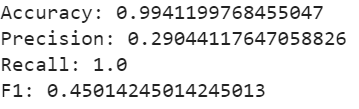

- <b>Decision Trees </b>


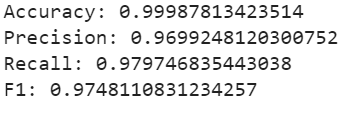

- <b> XGBoost </b>


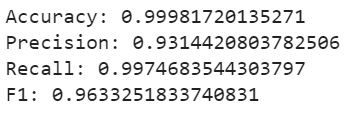

- <b> Keras </b>


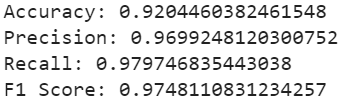

- <b> PyTorch </b>

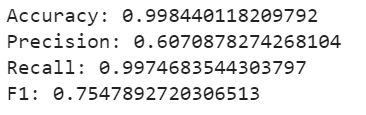

Since the dataset was imbalanced, we need to look at Precision, Recall, and F-1 score to evaluate the models.

The model with the lowest F-1 and Precision is Logistic Regression, even though it has the highest Recall. That means that this model returned a lot of false positives, i.e., there were a lot of asteroids that were predicted to be hazardous even though in truth, they were not. This is obviously a bit problematic but in reality wouldn't cause much problems as a false negative, which means that we predicted an asetoroid to not be hazardous when in truth it is hazardous. Overall, this is clearly not the best model.

The next worst model is, surprisingly, PyTorch. It has an F-1 score of approximately 0.75. This might be because of poor model tuning from my side or lack of enough data since neural networks generally work the best with lots of data. Once again, the precision score was low because of high number of false positives. 

XGBoost is the third best model and it has a very good F-1 score of 0.96 (approx). It has a very good recall and precision score.

The best models for this specifc problem are Neural Network using Keras and suprisingly, decision trees. They both have the same F-1 (0.97), recall (0.98), and precision scores (0.97). This means that the model is doing well to predict both classes despite the imbalance in data. Therefore, according to these metrics at least, we should use these algorithms to classify asteroids as PHA or not.

If I had more time to work on this project, I would have improved the PyTorch model by tuning the parameters and improving the score.